# (Optional) Colab Setup
If you aren't using Colab, you can delete the following code cell. This is just to help students with mounting to Google Drive to access the other .py files and downloading the data, which is a little trickier on Colab than on your local machine using Jupyter.

#Data Setup

The first thing to do is implement a dataset class to load rotated CIFAR10 images with matching labels. Since there is already a CIFAR10 dataset class implemented in `torchvision`, we will extend this class and modify the `__get_item__` method appropriately to load rotated images.

Each rotation label should be an integer in the set {0, 1, 2, 3} which correspond to rotations of 0, 90, 180, or 270 degrees respectively.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random


def rotate_img(img, rot):
  if rot == 0: # 0 degrees rotation
    return img
  # TODO: Implement rotate_img() - return the rotated img
  elif rot == 1:
    return torch.rot90(img, k=1, dims=(1, 2))
  elif rot == 2:
    return torch.rot90(img, k=2, dims=(1, 2))
  elif rot == 3:
    return torch.rot90(img, k=-1, dims=(1, 2))
  else:
    raise ValueError('rotation should be 0, 90, 180, or 270 degrees')


class CIFAR10Rotation(torchvision.datasets.CIFAR10):

    def __init__(self, root, train, download, transform) -> None:
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        image, cls_label = super().__getitem__(index)

        # randomly select image rotation
        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label)

        rotation_label = torch.tensor(rotation_label).long()
        return image, image_rotated, rotation_label, torch.tensor(cls_label).long()

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

trainset = CIFAR10Rotation(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = CIFAR10Rotation(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:02<00:00, 82049437.19it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Show some example images and rotated images with labels:

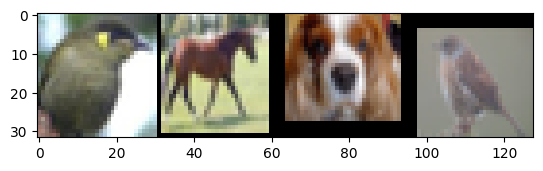

Class labels:  bird  horse dog   bird 


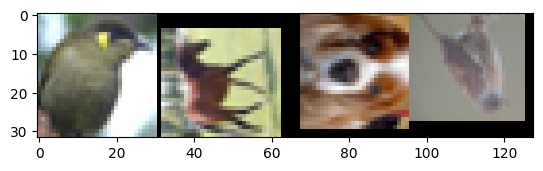

Rotation labels:  0     90    270   180  


In [ ]:
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

rot_classes = ('0', '90', '180', '270')


def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, rot_images, rot_labels, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

# Evaluation code

In [ ]:
import time

def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)
            # TODO: Calculate outputs by running images through the network
            outputs = net(images)
            # loss
            avg_test_loss += criterion(outputs, labels)  / len(testloader)

            predicted = torch.argmax(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')

In [ ]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train a ResNet18 on the rotation task

### In this section, we will train a ResNet18 model on the rotation task. The input is a rotated image and the model predicts the rotation label. See the Data Setup section for details.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(num_classes=4)
net = net.to(device)

In [ ]:
import torch.optim as optim
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.002)

In [ ]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, data in enumerate(trainloader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)

            # TODO: Set the data to the correct device; Different task will use different inputs and labels
            imgs, imgs_rotated, rotation_label, cls_label = data
            imgs, imgs_rotated, rotation_label, cls_label = imgs.to(device), imgs_rotated.to(device), rotation_label.to(device), cls_label.to(device)

            # TODO: Zero the parameter gradients
            optimizer.zero_grad()
            outputs = net(imgs_rotated)
            loss = criterion(outputs, rotation_label)
            loss.backward()
            optimizer.step()
            # TODO: Get predicted results
            predicted = torch.argmax(outputs, dim=1)

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += rotation_label.size(0)
            running_correct += (predicted == rotation_label).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.
        run_test(net, testloader, criterion, "rotation")

    print('Finished Training')

In [ ]:
train(net, criterion, optimizer, num_epochs=45, decay_epochs=15, init_lr=0.01, task='rotation')

[1,   100] loss: 1.481 acc: 35.73 time: 6.11
[1,   200] loss: 1.235 acc: 44.17 time: 4.15
[1,   300] loss: 1.166 acc: 47.92 time: 4.15
TESTING:
Accuracy of the network on the 10000 test images: 51.35 %
Average loss on the 10000 test images: 1.124
[2,   100] loss: 1.143 acc: 49.88 time: 4.39
[2,   200] loss: 1.110 acc: 52.18 time: 4.35
[2,   300] loss: 1.073 acc: 53.80 time: 4.48
TESTING:
Accuracy of the network on the 10000 test images: 55.89 %
Average loss on the 10000 test images: 1.030
[3,   100] loss: 1.055 acc: 54.79 time: 4.53
[3,   200] loss: 1.035 acc: 56.18 time: 4.31
[3,   300] loss: 1.025 acc: 56.66 time: 4.39
TESTING:
Accuracy of the network on the 10000 test images: 59.01 %
Average loss on the 10000 test images: 0.979
[4,   100] loss: 0.989 acc: 58.52 time: 4.54
[4,   200] loss: 0.997 acc: 57.73 time: 4.40
[4,   300] loss: 0.969 acc: 59.13 time: 4.40
TESTING:
Accuracy of the network on the 10000 test images: 60.45 %
Average loss on the 10000 test images: 0.949
[5,   100] l

In [ ]:
# TODO: Save the model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

# Fine-tuning on the pre-trained model
### In this section, we will load the pre-trained ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(num_classes=10).to(device)
net_params = torch.load(PATH)
net_params['fc.weight'] = torch.randn(10, net_params['fc.weight'].shape[1])
net_params['fc.bias'] = torch.randn(10)
net.load_state_dict(net_params)

<All keys matched successfully>

In [ ]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
for param in net.parameters():
    param.requires_grad = False
for param in net.layer4.parameters():
    param.requires_grad = True
for param in net.fc.parameters():
    param.requires_grad = True

In [ ]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [ ]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')


[1,   100] loss: 0.838 acc: 73.67 time: 4.18
[1,   200] loss: 0.598 acc: 77.02 time: 3.95
[1,   300] loss: 0.583 acc: 77.45 time: 3.94
TESTING:
Accuracy of the network on the 10000 test images: 77.25 %
Average loss on the 10000 test images: 0.584
[2,   100] loss: 0.570 acc: 77.41 time: 3.93
[2,   200] loss: 0.565 acc: 78.09 time: 3.82
[2,   300] loss: 0.557 acc: 78.29 time: 3.84
TESTING:
Accuracy of the network on the 10000 test images: 76.71 %
Average loss on the 10000 test images: 0.594
[3,   100] loss: 0.560 acc: 78.09 time: 4.10
[3,   200] loss: 0.572 acc: 77.91 time: 3.88
[3,   300] loss: 0.560 acc: 78.04 time: 4.04
TESTING:
Accuracy of the network on the 10000 test images: 77.02 %
Average loss on the 10000 test images: 0.584
[4,   100] loss: 0.580 acc: 78.17 time: 4.08
[4,   200] loss: 0.556 acc: 78.24 time: 3.90
[4,   300] loss: 0.557 acc: 78.45 time: 3.97
TESTING:
Accuracy of the network on the 10000 test images: 76.89 %
Average loss on the 10000 test images: 0.584
[5,   100] l

# Fine-tuning on the randomly initialized model
### In this section, we will randomly initialize a ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model
net = resnet18(num_classes=10).to(device)

In [ ]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
# To do this, you should set requires_grad=False for the frozen layers.
for param in net.parameters():
    param.requires_grad = False
for param in net.layer4.parameters():
    param.requires_grad = True
for param in net.fc.parameters():
    param.requires_grad = True

In [ ]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [ ]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 1.497 acc: 34.27 time: 4.05
[1,   200] loss: 1.320 acc: 39.25 time: 3.98
[1,   300] loss: 1.292 acc: 40.82 time: 4.03
TESTING:
Accuracy of the network on the 10000 test images: 42.77 %
Average loss on the 10000 test images: 1.248
[2,   100] loss: 1.251 acc: 43.05 time: 3.99
[2,   200] loss: 1.241 acc: 43.10 time: 3.82
[2,   300] loss: 1.236 acc: 44.05 time: 3.85
TESTING:
Accuracy of the network on the 10000 test images: 45.29 %
Average loss on the 10000 test images: 1.210
[3,   100] loss: 1.229 acc: 43.89 time: 4.06
[3,   200] loss: 1.213 acc: 45.42 time: 4.17
[3,   300] loss: 1.216 acc: 45.23 time: 3.85
TESTING:
Accuracy of the network on the 10000 test images: 48.16 %
Average loss on the 10000 test images: 1.175
[4,   100] loss: 1.202 acc: 45.69 time: 4.00
[4,   200] loss: 1.209 acc: 45.98 time: 3.89
[4,   300] loss: 1.201 acc: 45.91 time: 3.76
TESTING:
Accuracy of the network on the 10000 test images: 47.87 %
Average loss on the 10000 test images: 1.174
[5,   100] l

# Supervised training on the pre-trained model
### In this section, we will load the pre-trained ResNet18 model and re-train the whole model on the classification task.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Load the pre-trained ResNet18 model
net = resnet18(num_classes=10).to(device)
net_params = torch.load(PATH)
net_params['fc.weight'] = torch.randn(10, net_params['fc.weight'].shape[1])
net_params['fc.bias'] = torch.randn(10)
net.load_state_dict(net_params)

<All keys matched successfully>

In [ ]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 1.027 acc: 66.83 time: 4.87
[1,   200] loss: 0.687 acc: 73.51 time: 4.50
[1,   300] loss: 0.696 acc: 73.00 time: 4.41
TESTING:
Accuracy of the network on the 10000 test images: 69.39 %
Average loss on the 10000 test images: 0.777
[2,   100] loss: 1.086 acc: 59.95 time: 4.75
[2,   200] loss: 1.160 acc: 54.30 time: 4.58
[2,   300] loss: 1.000 acc: 59.91 time: 4.49
TESTING:
Accuracy of the network on the 10000 test images: 67.05 %
Average loss on the 10000 test images: 0.819
[3,   100] loss: 0.794 acc: 68.13 time: 4.77
[3,   200] loss: 0.738 acc: 70.16 time: 4.54
[3,   300] loss: 0.817 acc: 68.14 time: 4.49
TESTING:
Accuracy of the network on the 10000 test images: 69.73 %
Average loss on the 10000 test images: 0.768
[4,   100] loss: 0.798 acc: 68.77 time: 4.62
[4,   200] loss: 0.736 acc: 70.93 time: 4.56
[4,   300] loss: 0.693 acc: 72.46 time: 4.45
TESTING:
Accuracy of the network on the 10000 test images: 72.89 %
Average loss on the 10000 test images: 0.711
[5,   100] l

# Supervised training on the randomly initialized model
### In this section, we will randomly initialize a ResNet18 model and re-train the whole model on the classification task.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model
net = resnet18(num_classes=10, pretrained=False).to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 1.508 acc: 34.16 time: 4.76
[1,   200] loss: 1.253 acc: 44.12 time: 4.51
[1,   300] loss: 1.170 acc: 48.21 time: 4.45
TESTING:
Accuracy of the network on the 10000 test images: 53.33 %
Average loss on the 10000 test images: 1.080
[2,   100] loss: 1.116 acc: 51.80 time: 4.71
[2,   200] loss: 1.086 acc: 52.89 time: 4.54
[2,   300] loss: 1.073 acc: 53.77 time: 4.47
TESTING:
Accuracy of the network on the 10000 test images: 55.22 %
Average loss on the 10000 test images: 1.048
[3,   100] loss: 1.050 acc: 55.53 time: 4.78
[3,   200] loss: 1.026 acc: 56.73 time: 4.72
[3,   300] loss: 1.018 acc: 56.48 time: 4.54
TESTING:
Accuracy of the network on the 10000 test images: 57.64 %
Average loss on the 10000 test images: 0.983
[4,   100] loss: 1.001 acc: 57.87 time: 4.64
[4,   200] loss: 0.975 acc: 58.57 time: 4.51
[4,   300] loss: 0.972 acc: 59.16 time: 4.51
TESTING:
Accuracy of the network on the 10000 test images: 61.57 %
Average loss on the 10000 test images: 0.928
[5,   100] l

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!jupyter nbconvert --to pdf /content/drive/MyDrive/CS444/CS444HW3/assignment3_part1/a3_part1_rotation.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/CS444/CS444HW3/assignment3_part1/a3_part1_rotation.ipynb to pdf
[NbConvertApp] Support files will be in a3_part1_rotation_files/
[NbConvertApp] Making directory ./a3_part1_rotation_files
[NbConvertApp] Making directory ./a3_part1_rotation_files
[NbConvertApp] Writing 106073 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 137057 bytes to /content/drive/MyDrive/CS444/CS444HW3/assignment3_part1/a3_part1_rotation.pdf
